In [ ]:
"""import kagglehub

# Download latest version
path = kagglehub.dataset_download("solesensei/solesensei_bdd100k")

print("Path to dataset files:", path)


import shutil

# Define source and destination paths
source_path = "/root/.cache/kagglehub/datasets/solesensei/solesensei_bdd100k/versions/2"
destination_path = "/content/bdd100k"

# Move files
shutil.copytree(source_path, destination_path, dirs_exist_ok=True)

print("Dataset moved to:", destination_path)


100%|██████████| 7.61G/7.61G [01:34<00:00, 86.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/solesensei/solesensei_bdd100k/versions/2
Dataset moved to: /content/bdd100k


In [ ]:
"""from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Define destination in Google Drive
drive_destination = "/content/drive/MyDrive/bdd100k"

# Copy dataset to Google Drive
shutil.copytree(destination_path, drive_destination, dirs_exist_ok=True)

print("Dataset saved to Google Drive at:", drive_destination)


Mounted at /content/drive
Dataset saved to Google Drive at: /content/drive/MyDrive/bdd100k


In [1]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm


In [ ]:
import os
import shutil
from tqdm import tqdm

# Define paths
base_path = "/content/drive/MyDrive/bdd100k/bdd100k_seg/bdd100k/seg"
images_path = f"{base_path}/images"
masks_path = f"{base_path}/labels"
filtered_path = f"{base_path}/filtered_dataset"
filtered_images_path = f"{filtered_path}/filtered_images"
filtered_masks_path = f"{filtered_path}/filtered_masks"

# Create filtered directories if not exist
os.makedirs(filtered_images_path, exist_ok=True)
os.makedirs(filtered_masks_path, exist_ok=True)

# Gather all image and mask filenames
image_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if f.endswith(('.png', '.jpg', '.jpeg'))]
mask_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(masks_path) for f in filenames if f.endswith('_train_id.png')]

# Extract prefixes
image_prefixes = {os.path.basename(img).split('.')[0] for img in image_files}
mask_prefixes = {os.path.basename(mask).split('_train_id.png')[0] for mask in mask_files}

# Find matching prefixes
common_prefixes = image_prefixes & mask_prefixes

# Debugging logs
print(f"Number of images found: {len(image_files)}")
print(f"Number of masks found: {len(mask_files)}")
print(f"Number of matching prefixes: {len(common_prefixes)}")

# Filter and copy images and masks
for prefix in tqdm(common_prefixes, desc="Filtering images and masks"):
    # Find matching files
    img_file = next((img for img in image_files if os.path.basename(img).startswith(prefix)), None)
    mask_file = next((mask for mask in mask_files if os.path.basename(mask).startswith(prefix)), None)

    # Verify both files exist
    if img_file and mask_file:
        try:
            # Copy files to filtered directories
            shutil.copy(img_file, os.path.join(filtered_images_path, os.path.basename(img_file)))
            shutil.copy(mask_file, os.path.join(filtered_masks_path, os.path.basename(mask_file)))
        except Exception as e:
            print(f"Error copying files for prefix {prefix}: {e}")

print(f"Filtering completed!")
print(f"Filtered images saved in: {filtered_images_path}")
print(f"Filtered masks saved in: {filtered_masks_path}")


Number of images found: 10000
Number of masks found: 8000
Number of matching prefixes: 8000


Filtering images and masks: 100%|██████████| 8000/8000 [52:56<00:00,  2.52it/s]

Filtering completed!
Filtered images saved in: /content/drive/MyDrive/bdd100k/bdd100k_seg/bdd100k/seg/filtered_dataset/filtered_images
Filtered masks saved in: /content/drive/MyDrive/bdd100k/bdd100k_seg/bdd100k/seg/filtered_dataset/filtered_masks


In [ ]:
from PIL import Image
import os
from tqdm import tqdm

base_path = "/content/drive/MyDrive/bdd100k/bdd100k_seg/bdd100k/seg/filtered_dataset"
filtered_images_path = f"{base_path}/filtered_images"
filtered_masks_path = f"{base_path}/filtered_masks"
resized_images_path = f"{base_path}/resized_images"
resized_masks_path = f"{base_path}/resized_masks"

# Create directories for resized images and masks
os.makedirs(resized_images_path, exist_ok=True)
os.makedirs(resized_masks_path, exist_ok=True)

target_size = (256, 256)  # Adjust as needed

def resize_images(source_dir, target_dir):
    files = os.listdir(source_dir)
    for file_name in tqdm(files, desc=f"Resizing images in {os.path.basename(source_dir)}"):
        img_path = os.path.join(source_dir, file_name)
        img = Image.open(img_path)
        img = img.resize(target_size)
        img.save(os.path.join(target_dir, file_name))

resize_images(filtered_images_path, resized_images_path)
resize_images(filtered_masks_path, resized_masks_path)

print("Resizing completed!")
print(f"Resized images saved in: {resized_images_path}")
print(f"Resized masks saved in: {resized_masks_path}")


Resizing images in filtered_masks: 100%|██████████| 8000/8000 [05:51<00:00, 22.74it/s]

Resizing completed!
Resized images saved in: /content/drive/MyDrive/bdd100k/bdd100k_seg/bdd100k/seg/filtered_dataset/resized_images
Resized masks saved in: /content/drive/MyDrive/bdd100k/bdd100k_seg/bdd100k/seg/filtered_dataset/resized_masks


In [ ]:
from sklearn.model_selection import train_test_split
import shutil
import os
from tqdm import tqdm

resized_images_path = f"{base_path}/resized_images"
resized_masks_path = f"{base_path}/resized_masks"
split_output_path = f"{base_path}/split"

def split_dataset(images_dir, masks_dir, output_dir, test_size=0.2, val_size=0.1):
    images = sorted(os.listdir(images_dir))
    masks = sorted(os.listdir(masks_dir))
    train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(
        images, masks, test_size=(test_size + val_size), random_state=42)
    val_imgs, test_imgs, val_masks, test_masks = train_test_split(
        temp_imgs, temp_masks, test_size=test_size/(test_size + val_size), random_state=42)

    for split, img_list, mask_list in [("train", train_imgs, train_masks),
                                       ("val", val_imgs, val_masks),
                                       ("test", test_imgs, test_masks)]:
        split_images_path = f"{output_dir}/{split}/images"
        split_masks_path = f"{output_dir}/{split}/masks"
        os.makedirs(split_images_path, exist_ok=True)
        os.makedirs(split_masks_path, exist_ok=True)

        print(f"Copying files for {split} split...")
        for img, mask in tqdm(zip(img_list, mask_list), total=len(img_list), desc=f"Processing {split} split"):
            shutil.copy(os.path.join(images_dir, img), f"{split_images_path}/{img}")
            shutil.copy(os.path.join(masks_dir, mask), f"{split_masks_path}/{mask}")

split_dataset(resized_images_path, resized_masks_path, split_output_path)

print("Dataset splitting completed!")
print(f"Train/Val/Test datasets saved in: {split_output_path}")


Copying files for train split...


Processing train split: 100%|██████████| 5599/5599 [07:41<00:00, 12.12it/s]


Copying files for val split...


Processing val split: 100%|██████████| 800/800 [00:39<00:00, 20.09it/s]


Copying files for test split...


Processing test split: 100%|██████████| 1601/1601 [03:35<00:00,  7.42it/s]

Dataset splitting completed!
Train/Val/Test datasets saved in: /content/drive/MyDrive/bdd100k/bdd100k_seg/bdd100k/seg/filtered_dataset/split


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet101
from PIL import Image
import os
import numpy as np
from torch.utils.data import Dataset
from tqdm import tqdm

# Define Dataset class
class BDDDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, limit=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform

        # List all the images and labels in their respective directories
        self.image_paths = sorted(os.listdir(image_dir))
        self.label_paths = sorted(os.listdir(label_dir))

        # Limit dataset size if specified
        if limit:
            self.image_paths = self.image_paths[:limit]
            self.label_paths = self.label_paths[:limit]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_paths[idx])
        label_path = os.path.join(self.label_dir, self.label_paths[idx])

        image = Image.open(image_path).convert("RGB")
        label = Image.open(label_path)

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        return image, label

# Set directories
image_dir = '/content/drive/MyDrive/bdd100k/bdd100k_seg/bdd100k/seg/images/train'
label_dir = '/content/drive/MyDrivebdd100k/bdd100k_seg/bdd100k/seg/labels/train'

# Transformations for the input images and labels
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))  # You can reduce image size for faster training
])

# Limit dataset to a small number of images (e.g., 100 samples)
limit = 100  # You can adjust this number for testing

# Load the dataset with limit
dataset = BDDDataset(image_dir, label_dir, transform=transform, limit=limit)
train_loader = DataLoader(dataset, batch_size=2, shuffle=True)  # Reduce batch size

# Define DeepLabV3 model
model = deeplabv3_resnet101(pretrained=True)
model = model.train()

# Set optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Training loop (reduced epochs for faster testing)
for epoch in range(5):  # Only 2 epochs for testing
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        # Ensure labels are of type Long and have shape [batch_size, height, width]
        labels = labels.long()

        # Squeeze any extra dimensions if needed (e.g., to remove a channel dimension)
        labels = labels.squeeze(1)  # Remove extra dimension if labels are [batch_size, 1, height, width]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)['out']

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

# Save the model
torch.save(model.state_dict(), 'deeplabv3_model.pth')


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from tqdm import tqdm

# Custom Dataset
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")  # Load as grayscale

        if self.transform:
            # Apply the same transform to both the image and the mask
            image = self.transform(image)
            mask = self.transform(mask)

        # Convert the mask to long type for loss computation
        mask = torch.tensor(np.array(mask), dtype=torch.long)

        return image, mask

# Define the UNet model (placeholder, replace with your model)
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Load dataset
def load_dataset(image_dir, mask_dir):
    image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]
    mask_paths = [os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)]
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    dataset = SegmentationDataset(image_paths, mask_paths, transform)
    return dataset

# Training function
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define the training loop

def train_model(model, train_loader, criterion, optimizer, num_epochs=10, save_path="unetmodel.pth"):
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        print(f"\nEpoch {epoch+1}/{num_epochs} started.")

        # Using tqdm to show the batch progress for each epoch
        with tqdm(train_loader, unit='batch', ncols=100) as tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")  # Display epoch number
            for batch_idx, (images, labels) in enumerate(tepoch):
                # Ensure labels are in the correct format and remove extra dimension
                labels = labels.squeeze(1)  # Shape: [B, H, W] (e.g., [4, 256, 256])
                labels = labels.unsqueeze(1).float()  # Shape: [B, 1, H, W] (e.g., [4, 1, 256, 256])

                # Forward pass
                outputs = model(images)  # Model output shape: [B, 1, H, W]

                # Compute loss
                loss = criterion(outputs, labels)
                epoch_loss += loss.item()

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Update progress bar with current loss
                tepoch.set_postfix(loss=loss.item())

        # Print epoch loss after each epoch
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.6f}")

# Paths to your dataset
image_dir = "/content/bdd100k/bdd100k_seg/bdd100k/seg/images/train"  # Replace with the path to your images
mask_dir = "/content/bdd100k/bdd100k_seg/bdd100k/seg/labels/train"    # Replace with the path to your masks

# Initialize dataset and dataloader
dataset = load_dataset(image_dir, mask_dir)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Model, loss, and optimizer
model = SimpleUNet()
criterion = nn.BCEWithLogitsLoss()  # Suitable for binary segmentation
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=5, save_path="unetmodel.pth")

# Save the model
torch.save(model.state_dict(), 'unetmodel.pth')


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset  # Ensure Dataset is imported here
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from tqdm import tqdm

# Custom Dataset
class SegmentationDataset(Dataset):  # Dataset is now correctly imported
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")  # Load as grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask = torch.tensor(np.array(mask), dtype=torch.long)

        return image, mask


# Define the U-Net model
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Load dataset
def load_dataset(image_dir, mask_dir):
    image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]
    mask_paths = [os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)]
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    dataset = SegmentationDataset(image_paths, mask_paths, transform)
    return dataset

# Paths to dataset
image_dir = "/content/drive/MyDrive/bdd100k/bdd100k_seg/bdd100k/seg/filtered_dataset/split/train/images"
mask_dir = "/content/drive/MyDrive/bdd100k/bdd100k_seg/bdd100k/seg/filtered_dataset/split/train/masks"

# Initialize dataset and dataloader
dataset = load_dataset(image_dir, mask_dir)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Initialize the model and load saved weights
model = SimpleUNet()
model.load_state_dict(torch.load("/content/drive/MyDrive/unetmodel.pth"))

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Suitable for binary segmentation
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Continue training
def train_model(model, train_loader, criterion, optimizer, num_epochs=5, save_path="unetmodel_retrained.pth"):
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        print(f"\nEpoch {epoch+1}/{num_epochs} started.")

        with tqdm(train_loader, unit='batch', ncols=100) as tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")
            for images, labels in tepoch:
                images, labels = images.to(device), labels.to(device)

                # Ensure labels have the correct shape (B, 1, H, W)
                if len(labels.shape) > 3:
                    labels = labels.squeeze(1)  # Remove extra dimensions

                labels = labels.unsqueeze(1).float()  # Ensure shape is (B, 1, H, W)

                optimizer.zero_grad()
                outputs = model(images)  # Output shape: (B, 1, H, W)
                loss = criterion(outputs, labels)  # BCEWithLogitsLoss expects both tensors to match
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())

        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.6f}")

# Retrain for 5 more epochs
train_model(model, train_loader, criterion, optimizer, num_epochs=5, save_path="unetmodel_retrained.pth")

# Save the updated model
torch.save(model.state_dict(), "/content/drive/MyDrive/unetmodel_retrained.pth")


<ipython-input-7-d3d70eaab401>:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/unetmodel.pth"))



Epoch 1/5 started.


Epoch 1/5: 100%|███████████████████████████████| 1400/1400 [1:21:13<00:00,  3.48s/batch, loss=0.693]


Epoch 1, Loss: 0.693129

Epoch 2/5 started.


Epoch 2/5: 100%|█████████████████████████████████| 1400/1400 [01:07<00:00, 20.85batch/s, loss=0.692]


Epoch 2, Loss: 0.692787

Epoch 3/5 started.


Epoch 3/5: 100%|█████████████████████████████████| 1400/1400 [01:07<00:00, 20.76batch/s, loss=0.694]


Epoch 3, Loss: 0.692531

Epoch 4/5 started.


Epoch 4/5: 100%|█████████████████████████████████| 1400/1400 [01:07<00:00, 20.67batch/s, loss=0.692]


Epoch 4, Loss: 0.692416

Epoch 5/5 started.


Epoch 5/5: 100%|█████████████████████████████████| 1400/1400 [01:06<00:00, 21.09batch/s, loss=0.714]

Epoch 5, Loss: 0.692282


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models.segmentation import deeplabv3_resnet101
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm

# Define Dataset class
class BDDDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, label_dir, transform=None, limit=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform

        self.image_paths = sorted(os.listdir(image_dir))
        self.label_paths = sorted(os.listdir(label_dir))

        if limit:
            self.image_paths = self.image_paths[:limit]
            self.label_paths = self.label_paths[:limit]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_paths[idx])
        label_path = os.path.join(self.label_dir, self.label_paths[idx])

        image = Image.open(image_path).convert("RGB")
        label = Image.open(label_path)

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        label = torch.tensor(label, dtype=torch.long)
        return image, label

# Paths for dataset
image_dir = '/content/drive/MyDrive/bdd100k/bdd100k_seg/bdd100k/seg/filtered_dataset/split/train/images'
label_dir = '/content/drive/MyDrive/bdd100k/bdd100k_seg/bdd100k/seg/filtered_dataset/split/train/masks'

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))
])

# Dataset and DataLoader
dataset = BDDDataset(image_dir, label_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Initialize DeepLabV3 with `num_classes=2`
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deeplab_model = deeplabv3_resnet101(pretrained=True)  # Load pretrained weights
deeplab_model.classifier[4] = nn.Conv2d(256, 2, kernel_size=1)  # Update classifier for 2 classes
deeplab_model.aux_classifier[4] = nn.Conv2d(256, 2, kernel_size=1)  # Update aux_classifier for 2 classes
deeplab_model = deeplab_model.to(device)

# Load the weights of the previously saved model safely
saved_model_path = '/content/drive/MyDrive/deeplabv3_model.pth'
checkpoint = torch.load(saved_model_path, map_location=device)

# Filter out incompatible layers
state_dict = deeplab_model.state_dict()
for key in checkpoint.keys():
    if key in state_dict and checkpoint[key].shape == state_dict[key].shape:
        state_dict[key] = checkpoint[key]

# Load filtered weights into the model
deeplab_model.load_state_dict(state_dict)

# Set loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(deeplab_model.parameters(), lr=0.0001)

# Continue training for 5 more epochs
num_epochs = 5
deeplab_model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    print(f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.squeeze(1).to(device)  # Ensure correct format

        optimizer.zero_grad()
        outputs = deeplab_model(images)['out']
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.6f}")

# Save the retrained model
torch.save(deeplab_model.state_dict(), '/content/drive/MyDrive/deeplabv3_model_retrained.pth')


<ipython-input-4-8f3a8b849571>:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(saved_model_path, map_location=device)


Epoch 1/5


  0%|          | 0/1400 [00:00<?, ?it/s]<ipython-input-4-8f3a8b849571>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long)
100%|██████████| 1400/1400 [46:35<00:00,  2.00s/it]


Epoch 1, Loss: 0.225904
Epoch 2/5


100%|██████████| 1400/1400 [12:22<00:00,  1.89it/s]


Epoch 2, Loss: 0.185700
Epoch 3/5


100%|██████████| 1400/1400 [12:21<00:00,  1.89it/s]


Epoch 3, Loss: 0.169633
Epoch 4/5


100%|██████████| 1400/1400 [12:22<00:00,  1.89it/s]


Epoch 4, Loss: 0.158283
Epoch 5/5


100%|██████████| 1400/1400 [12:22<00:00,  1.89it/s]


Epoch 5, Loss: 0.147201


<ipython-input-11-fc9be4fe092b>:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/unetmodel_retrained.pth", map_loca

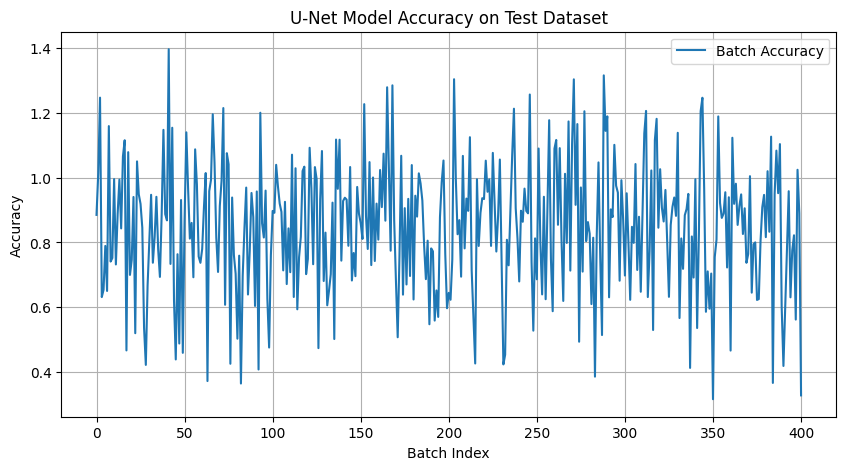

In [11]:
import torch
from torch.utils.data import DataLoader, Dataset  # Ensure Dataset is imported
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from tqdm import tqdm

# Custom Dataset (reuse from the training code)
class SegmentationDataset(Dataset):  # Redefined here
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")  # Load as grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask = torch.tensor(np.array(mask), dtype=torch.float32)  # Convert to float32 for BCEWithLogitsLoss

        return image, mask

# Load dataset
def load_dataset(image_dir, mask_dir):
    image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]
    mask_paths = [os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)]
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    dataset = SegmentationDataset(image_paths, mask_paths, transform)
    return dataset

# Paths to test dataset
test_image_dir = "/content/drive/MyDrive/bdd100k/bdd100k_seg/bdd100k/seg/filtered_dataset/split/test/images"
test_mask_dir = "/content/drive/MyDrive/bdd100k/bdd100k_seg/bdd100k/seg/filtered_dataset/split/test/masks"

# Load test dataset
test_dataset = load_dataset(test_image_dir, test_mask_dir)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Define and load U-Net model
class SimpleUNet(torch.nn.Module):  # Redefine SimpleUNet
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Load U-Net model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleUNet()
model.load_state_dict(torch.load("/content/drive/MyDrive/unetmodel_retrained.pth", map_location=device))
model.to(device)
model.eval()

# Accuracy calculation
def calculate_accuracy(predictions, masks):
    predictions = predictions > 0.5  # Convert logits to binary
    correct = (predictions == masks).sum().item()
    total = torch.numel(masks)
    return correct / total

accuracies = []
with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Evaluating U-Net"):
        images, masks = images.to(device), masks.to(device)
        masks = masks.unsqueeze(1)  # Ensure masks shape matches output
        outputs = model(images)
        accuracy = calculate_accuracy(outputs, masks)
        accuracies.append(accuracy)

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(accuracies, label="Batch Accuracy")
plt.xlabel("Batch Index")
plt.ylabel("Accuracy")
plt.title("U-Net Model Accuracy on Test Dataset")
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-15-da2bc6ba8af9>:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state_dict = torch.load('/content/drive/MyDrive/deeplabv3_model_retrained.pth', map_l

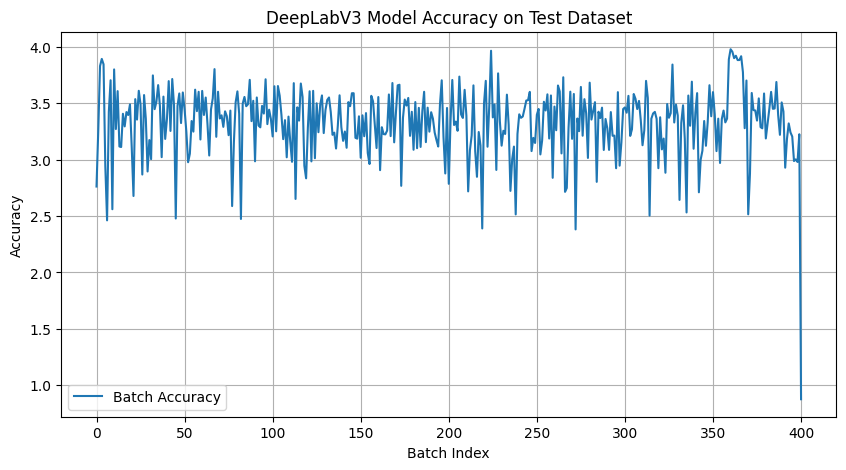

In [15]:
import torch
import matplotlib.pyplot as plt
from torchvision.models.segmentation import deeplabv3_resnet101
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import os

# Define Dataset class
class BDDDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform

        self.image_paths = sorted(os.listdir(image_dir))
        self.label_paths = sorted(os.listdir(label_dir))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_paths[idx])
        label_path = os.path.join(self.label_dir, self.label_paths[idx])

        image = Image.open(image_path).convert("RGB")
        label = Image.open(label_path)

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        label = torch.tensor(label, dtype=torch.long)
        return image, label

# Paths for the test dataset
test_image_dir = '/content/drive/MyDrive/bdd100k/bdd100k_seg/bdd100k/seg/filtered_dataset/split/test/images'
test_label_dir = '/content/drive/MyDrive/bdd100k/bdd100k_seg/bdd100k/seg/filtered_dataset/split/test/masks'

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))
])

# Dataset and DataLoader
test_dataset = BDDDataset(test_image_dir, test_label_dir, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

# Load retrained DeepLabV3 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deeplab_model = deeplabv3_resnet101(pretrained=False)  # Initialize without pretrained weights
deeplab_model.classifier[4] = torch.nn.Conv2d(256, 2, kernel_size=1)  # Update for 2 classes
if deeplab_model.aux_classifier is not None:  # Check if aux_classifier exists
    deeplab_model.aux_classifier[4] = torch.nn.Conv2d(256, 2, kernel_size=1)  # Update aux_classifier

# Load saved state_dict while filtering incompatible layers
saved_state_dict = torch.load('/content/drive/MyDrive/deeplabv3_model_retrained.pth', map_location=device)
model_state_dict = deeplab_model.state_dict()

# Filter keys to ensure compatibility
filtered_state_dict = {k: v for k, v in saved_state_dict.items() if k in model_state_dict and model_state_dict[k].shape == v.shape}

# Update model's state_dict
model_state_dict.update(filtered_state_dict)
deeplab_model.load_state_dict(model_state_dict)

deeplab_model.to(device)
deeplab_model.eval()

# Accuracy calculation
def calculate_accuracy(predictions, masks):
    predictions = predictions.argmax(dim=1)  # Get class predictions
    correct = (predictions == masks).sum().item()
    total = masks.numel()
    return correct / total

# Evaluate and plot accuracy
accuracies = []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating DeepLabV3"):
        images, labels = images.to(device), labels.to(device)
        outputs = deeplab_model(images)['out']
        accuracy = calculate_accuracy(outputs, labels)
        accuracies.append(accuracy)

# Plot batch-wise accuracy
plt.figure(figsize=(10, 5))
plt.plot(accuracies, label="Batch Accuracy")
plt.xlabel("Batch Index")
plt.ylabel("Accuracy")
plt.title("DeepLabV3 Model Accuracy on Test Dataset")
plt.legend()
plt.grid(True)
plt.show()
